In [70]:
import os
import torch
import pickle
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.datasets as datasets
import requests

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Imports

In [71]:
# Imports
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import string
from nltk.tokenize import word_tokenize
import nltk
import torch.nn as nn
from torch.nn.functional import softmax
import torchvision.transforms.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from torchvision import transforms
import torchvision.models as models
import torch
from torch.utils.data import DataLoader, Dataset
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Building Image Captioning in PyTorch

The goal of image captioning is to describe a given image using natural language. Using neural networks, we can partition the problem into two separate challenges. First, we need to extract meaningful features regarding the image that would help us describe it. Second, we need to generate a sequence of words that best fit those features. Luckily, the flexibility of neural networks allows us to take a CNN architecture and connect it directly to a LSTM network with an appropriate attention mechanism to appropriately weight the feature maps.

1. Read about and download the Flickr8k dataset from <a href="https://www.kaggle.com/adityajn105/flickr8k/activity">here</a> .

1. Create a preprocessing pipeline by creating a custom Pytorch  <a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">dataset</a>. Note that the data contains both images and caption annotation, so you will need to encode the text and map each character to an integer\One-hot vector (Remember to add start of sentence and end of sentence tokens) and apply torchvision.transforms to normalize the images as was done in previous homeworks.

1. Define the feature extractor. This model should take in an image and perform feature extraction on it. You can use a pretrained network such as ResNet (remember to normalize the input image) for this task or create your own Network.

1. Implement an attention mechanism as was described in class that will weight the feature maps for the RNN model.

1. Feed the feature maps that were weighted by the attention mechanism into the LSTM\GRU\RNN decoder that will generate the actual captions.

1. Train your model. Training a proper model might take a while, so you are encouraged to use [Colab](https://colab.research.google.com/).

6. Create function that takes the learned network and predicts a single word. This function should take a hidden state and an input character, and output the next hidden state and the predicted word.
7. Finally, create a sampling function that takes the network, the maximum length of text and produces a caption.


In [72]:
# Your code goes here

In [73]:
###################
##### Utils #######
###################

def clean_caption(caption):
    # Cleaning the text
    caption = [ch for ch in caption if ch not in string.punctuation]
    caption = ''.join(caption)
    caption = caption.split(' ')
    caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
    caption = ' '.join(caption)
    return caption


def to_vocab(captions):
    # Generate the Vocabulary
    words = set()
    for caption in captions:
        words.update(caption.split())
    return words

# show the tensor image
import matplotlib.pyplot as plt


def show_image(img, title=None):
    """Imshow for Tensor."""
    # unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))

    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

# sampling function that takes the network, the maximum length of text and produces a caption.
def sampling_and_captioning(data_loader, data_set, model, device, max_length_text=25):
    data = next(iter(data_loader))  # randomly sample data
    image = data['image']
    features = model.encoder_cnn(image[0:1].to(device))
    words, alphas = model.attention_decoder_rnn.generate_caption(features, max_length_text, data_set=data_set)
    caption = ' '.join(words)
    show_image(image[0], title=caption)
    return caption


def visualize_attention(orig_image, words, attenion_weights):
    """Plots attention in the image sample.

    Arguments:
    ----------
    - orig_image - image of original size
    - words - list of tokens
    - attenion_weights - list of attention weights at each time step
    """
    fig = plt.figure(figsize=(14, 12))
    len_tokens = len(words)

    for i in range(len(words)):
        attenion_current = attenion_weights[i].detach().numpy()
        attenion_current = attenion_current.reshape(7,7)
        ax = fig.add_subplot(len_tokens//2, len_tokens//2, i+1)
        ax.set_title(words[i])
        img = ax.imshow(np.squeeze(orig_image))
        ax.imshow(attenion_current, cmap='gray', alpha=0.8, extent=img.get_extent(), interpolation = 'bicubic')
    plt.tight_layout()
    plt.show()


In [74]:
##########################
##### Custom Dataset #####
##########################

class ImageCaptionDataset(Dataset):
    """Image Caption Custom dataset."""

    def __init__(self, annotations_file: str, images_dir: str,
                 transform, max_seq_length: int = 20):
        """
        :param:
            annotations_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform: transform to be applied on the image sample.
        """
        self.max_seq_length = max_seq_length

        print("Reading data...")
        df = pd.read_csv(annotations_file)
        df['caption'] = df['caption'].apply(clean_caption)
        self.df = df
        self.captions_column = self.df['caption']
        self.image_name_column = self.df['image']

        self.df['length'] = self.captions_column.apply(lambda x: len(x.split()))
        self.length_column = self.df['length']

        self.images_dir = images_dir
        self.transform = transform

        # create Vocabulary and the mapping
        words = to_vocab(self.captions_column)
        # add special tokens
        words.add('<start>')
        words.add('<end>')
        words.add('<PAD>')
        self.word_to_idx_mapping = dict([(word, idx) for idx, word in enumerate(words)])
        self.idx_to_word_mapping = dict([(idx, word) for idx, word in enumerate(words)])
        self.vocab_size = len(words)
        print("Ready !")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # take the image name contained in the csv file
        image_name = os.path.join(self.images_dir, self.image_name_column[idx])
        # read the true image based on that name
        image = Image.open(image_name).convert('RGB')
        # read df & transform caption to tensor:
        caption = self.captions_column[idx]
        # tokenize
        tokens = word_tokenize(caption)
        # add special tokens for start and end of seq
        caption = []
        caption.append('<start>')
        caption.extend([token for token in tokens])
        caption.append('<end>')
        # Map to integer
        caption = [self.word_to_idx_mapping[i] for i in caption]
        # pad sequence
        caption = self.pad_data(caption)

        sample = {'image': image, 'caption': caption}
        # transform
        sample = self.transform(sample)
        return sample

    def pad_data(self, seq):
        padded = np.ones((self.max_seq_length,), dtype=np.int64) * self.word_to_idx_mapping['<PAD>']

        if len(seq) > self.max_seq_length:
            padded[:] = seq[:self.max_seq_length]
        else:
            padded[:len(seq)] = seq

        return padded


In [75]:

#############################
######## Preprocessing ######
#############################

class ToTensor(object):
    def __call__(self, sample):
        pic = sample['image']
        sample['image'] = F.to_tensor(pic)
        return sample

    def __repr__(self):
        return self.__class__.__name__ + '()'


class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['caption']
        h, w = image.size[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = F.resize(image, (new_h, new_w))
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        return {'image': img, 'caption': label}


class Normalize(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, sample):
        img = sample['image']
        sample['image'] = F.normalize(img, self.mean, self.std)
        return sample

In [76]:
##############################
##### Data Loading  ##########
##############################

def create_dataset(annotations_file, images_dir):
    # with open(mapper_file, 'rb') as f:
    # 	vocab = pickle.load(f)

    transform = transforms.Compose([
        Rescale((224, 224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalizing according to imagenet
    ])

    train_set = ImageCaptionDataset(annotations_file, images_dir, transform)
    vocab = train_set.word_to_idx_mapping
    return train_set, vocab


def train_valid_split(training_set, validation_size):
    """ Function that split our dataset into train and validation
        given in parameter the training set and the % of sample for validation"""

    # obtain training indices that will be used for validation
    num_train = len(training_set)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(validation_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    return train_sampler, valid_sampler


def build_loaders(train_set, train_sampler, valid_sampler, batch_size, valid_size, num_workers):
    train_sampler, valid_sampler = train_valid_split(train_set, valid_size)
    train_loader = DataLoader(train_set,
                              batch_size=batch_size,
                              sampler=train_sampler,
                              num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=num_workers)
    return train_loader, valid_loader

In [77]:
######################
######## Models ######
######################

class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.resnet(images)  # (batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)  # (batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1))  # (batch_size,49,2048)
        return features


# Bahdanau Attention
# https://arxiv.org/abs/1409.0473
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        self.attention_dim = attention_dim

        self.W = nn.Linear(decoder_dim, attention_dim)
        self.U = nn.Linear(encoder_dim, attention_dim)

        self.A = nn.Linear(attention_dim, 1)

    def forward(self, features, hidden_state):
        ''':param:
            Features with dim of: (batch_size, num_layers, attention_dim)
            Hidden state with dim of (batch_size, attention_dim)
        '''
        u_hs = self.U(features)
        w_ah = self.W(hidden_state)

        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1))  # dim (batch_size, num_layers, attention_dim)

        attention_scores = self.A(combined_states)  # dim (batch_size, num_layers, 1)
        attention_scores = attention_scores.squeeze(2)  # dim (batch_size, num_layers)

        alpha = softmax(attention_scores, dim=1)  # dim (batch_size, num_layers)

        attention_weights = features * alpha.unsqueeze(2)  # dim (batch_size, num_layers, features_dim)
        attention_weights = attention_weights.sum(dim=1)  # dim (batch_size, num_layers)

        return alpha, attention_weights


# Attention Decoder LSTM
class AttentionDecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, device, drop_prob=0.3):
        super().__init__()

        self.device = device

        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)

        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        '''':param:
            features: images extracted features
            captions: images captions '''

        # vectorize the caption
        embeddings = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # dim (batch_size, decoder_dim)

        # get the seq length to iterate
        seq_length = len(captions[0]) - 1
        batch_size = captions.size(0)
        num_features = features.size(1)

        outputs = torch.zeros(batch_size, seq_length, self.vocab_size).to(self.device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(self.device)

        for i in range(seq_length):
            alpha, context = self.attention(features, h)
            lstm_input = torch.cat((embeddings[:, i], context), dim=1)
            h, c = self.lstm(lstm_input, (h, c))

            output = self.fc(self.drop(h))

            outputs[:, i] = output
            alphas[:, i] = alpha

        return outputs, alphas


    def generate_caption(self, features, max_length_text, data_set):
        '''
        Inference part: Given the image features generate the captions
        '''
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        alphas = []

        # starting input
        word = torch.tensor(data_set.word_to_idx_mapping['<start>']).view(1, -1).to(self.device)
        embeddings = self.embedding(word)

        captions = []

        for i in range(max_length_text):
            alpha, context = self.attention(features, h)

            # append the alpha score
            alphas.append(alpha.cpu().detach().numpy())

            lstm_input = torch.cat((embeddings[:, 0], context), dim=1)
            h, c = self.lstm(lstm_input, (h, c))

            output = self.fc(self.drop(h))
            output = output.view(batch_size, -1)

            # select the word with maximum prob val
            word_idx_prediction = output.argmax(dim=1)

            # add the generated word idx
            captions.append(word_idx_prediction.item())

            # end if <end> token predicted
            if data_set.idx_to_word_mapping[word_idx_prediction.item()] == "<end>":
                captions = captions[:-1]  # remove the <end> token
                break

            # generated word as the next
            embeddings = self.embedding(word_idx_prediction.unsqueeze(0))

        # convert the vocab idx to words and return sentence
        return [data_set.idx_to_word_mapping[idx] for idx in captions], alphas

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [78]:
################################
#### Combined Network ##########
################################

class EncoderCNNAttentionDecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, device, drop_prob=0.3):
        super().__init__()
        self.encoder_cnn = EncoderCNN()
        self.attention_decoder_rnn = AttentionDecoderRNN(
            embed_size=embed_size,
            vocab_size=vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
            device=device
        )
        self.device = device

    def forward(self, images, captions):
        extracted_features = self.encoder_cnn(images)
        return self.attention_decoder_rnn(extracted_features, captions)

# Training

Reading data...
Ready !
device is: cuda:0
Epoch: 1 loss: 5.58595


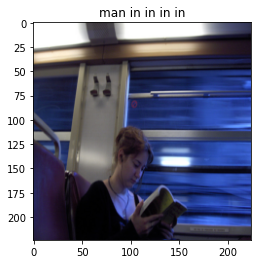

Epoch: 1 loss: 5.50220


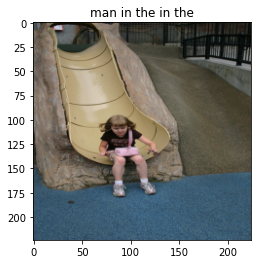

Epoch: 1 loss: 5.39157


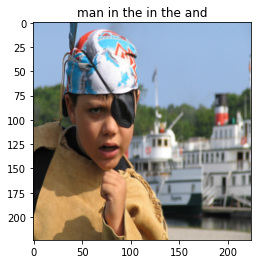

Epoch: 1 loss: 5.18122


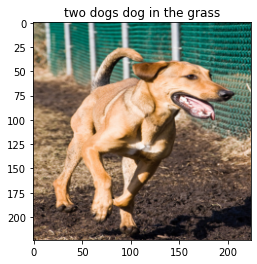

Epoch: 2 loss: 4.71907


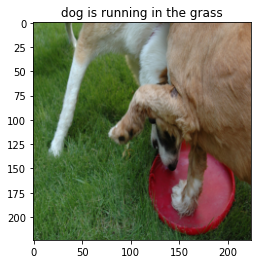

Epoch: 2 loss: 4.72253


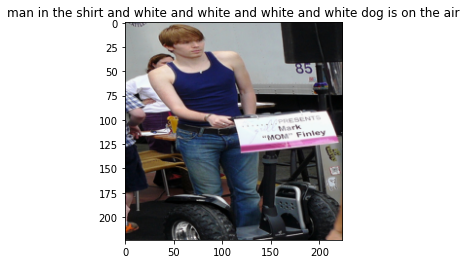

Epoch: 2 loss: 4.74197


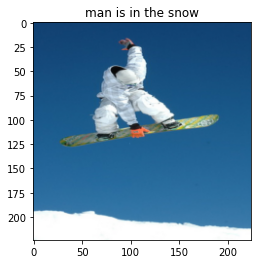

Epoch: 2 loss: 4.57118


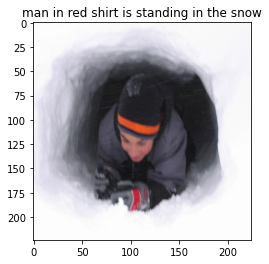

Epoch: 3 loss: 4.33036


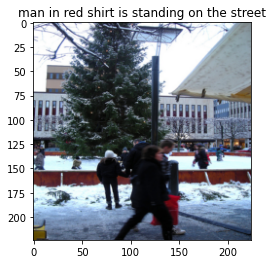

Epoch: 3 loss: 4.20724


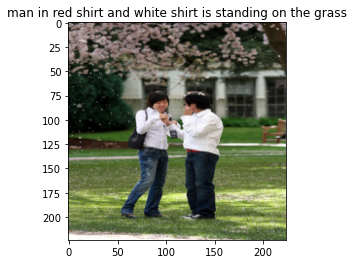

Epoch: 3 loss: 4.23678


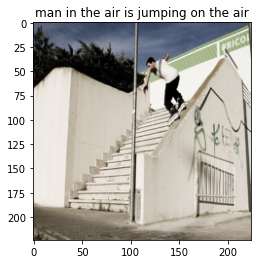

Epoch: 3 loss: 4.28707


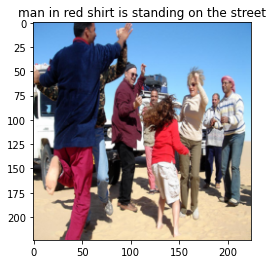

Epoch: 4 loss: 4.33228


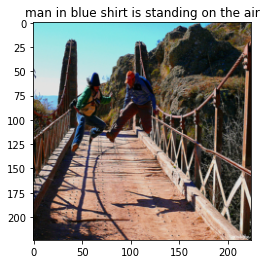

Epoch: 4 loss: 3.91772


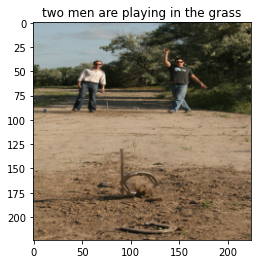

Epoch: 4 loss: 4.27514


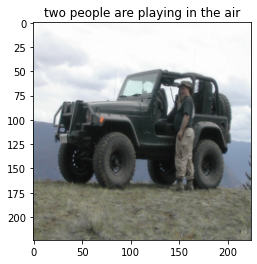

Epoch: 4 loss: 3.90921


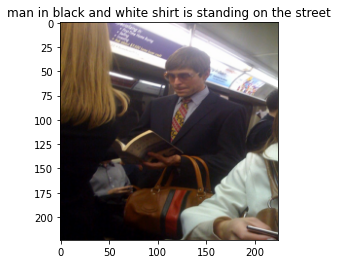

Epoch: 5 loss: 4.06807


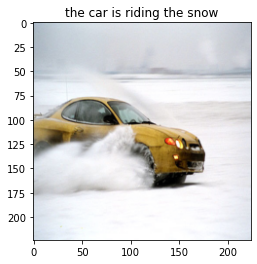

Epoch: 5 loss: 3.86182


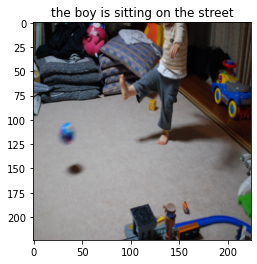

Epoch: 5 loss: 4.08603


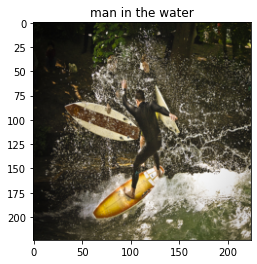

Epoch: 5 loss: 3.91206


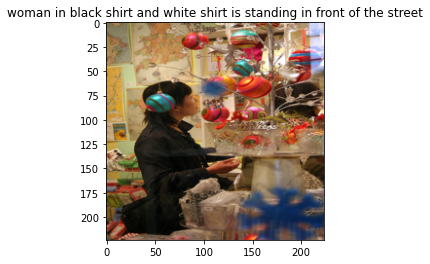

Epoch: 6 loss: 3.91210


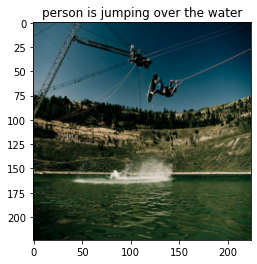

Epoch: 6 loss: 3.63417


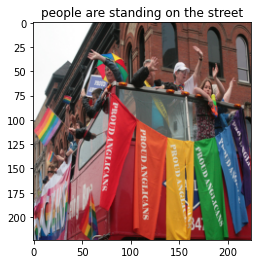

Epoch: 6 loss: 3.91300


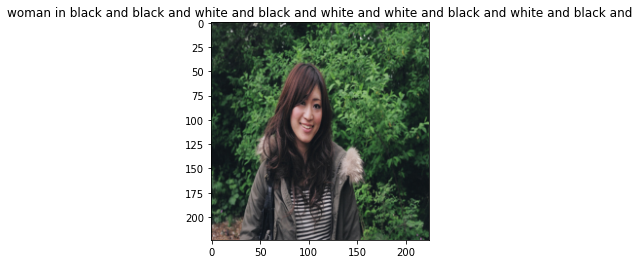

Epoch: 6 loss: 3.88940


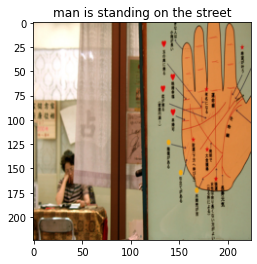

Epoch: 7 loss: 3.57184


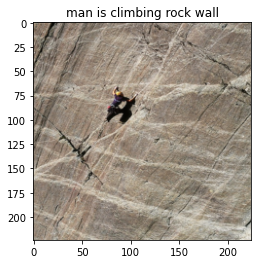

Epoch: 7 loss: 3.84148


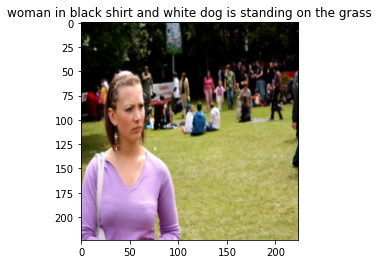

Epoch: 7 loss: 3.69333


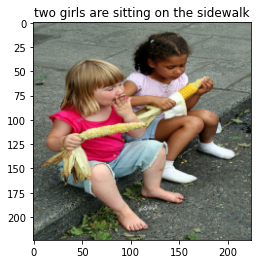

Epoch: 7 loss: 3.65089


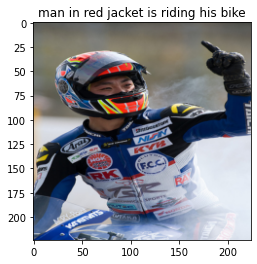

Epoch: 8 loss: 3.37085


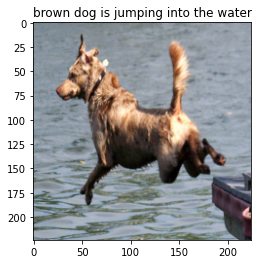

Epoch: 8 loss: 3.73778


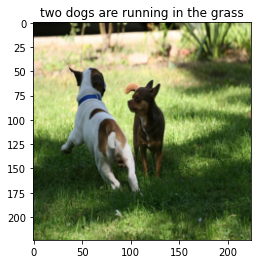

Epoch: 8 loss: 3.62195


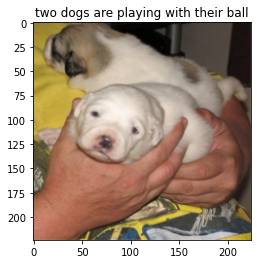

Epoch: 8 loss: 3.48509


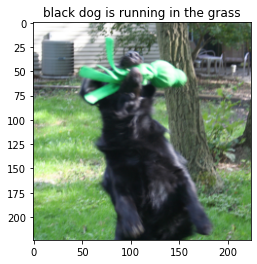

Epoch: 9 loss: 3.55515


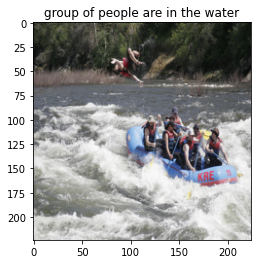

Epoch: 9 loss: 3.51607


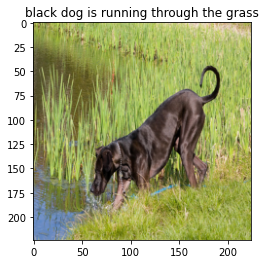

Epoch: 9 loss: 3.76975


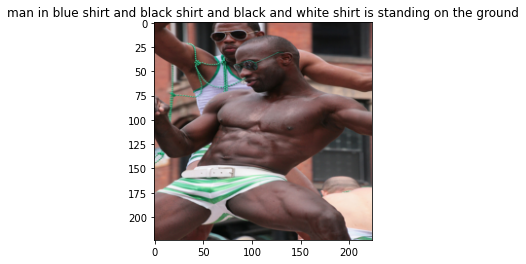

Epoch: 9 loss: 3.42101


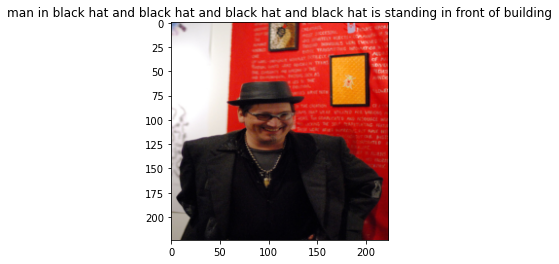

Epoch: 10 loss: 3.25764


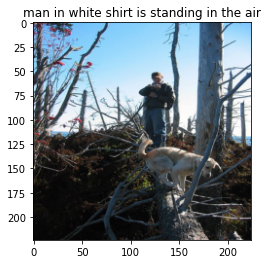

Epoch: 10 loss: 3.37098


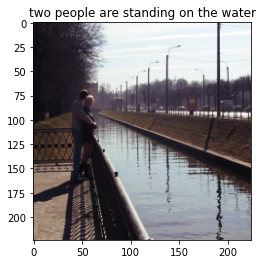

Epoch: 10 loss: 3.41102


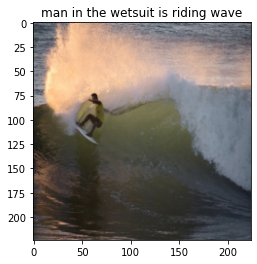

Epoch: 10 loss: 3.33899


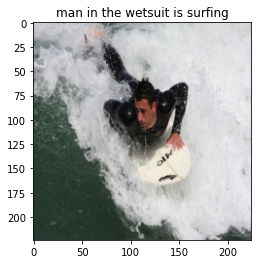

Epoch: 11 loss: 3.33806


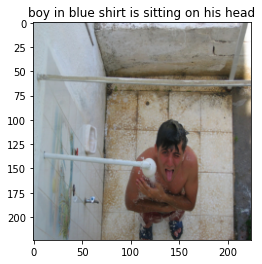

Epoch: 11 loss: 3.28932


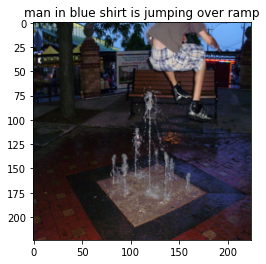

Epoch: 11 loss: 3.46573


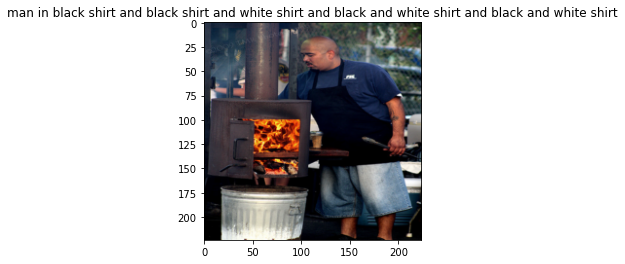

Epoch: 11 loss: 3.49155


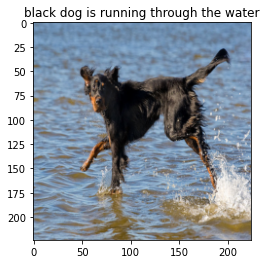

Epoch: 12 loss: 3.22369


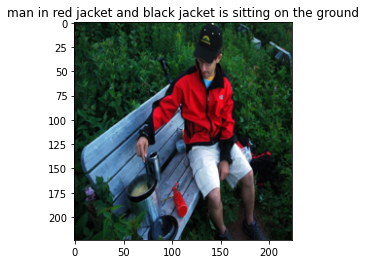

Epoch: 12 loss: 3.24060


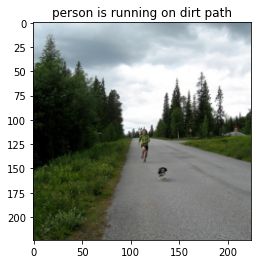

Epoch: 12 loss: 3.28645


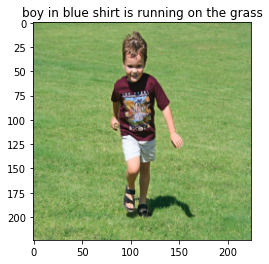

Epoch: 12 loss: 3.06069


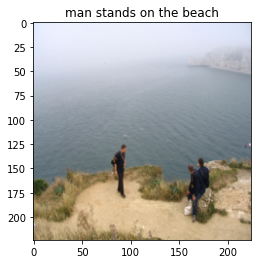

Epoch: 13 loss: 3.21044


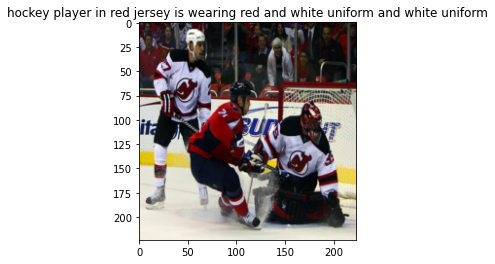

Epoch: 13 loss: 3.26678


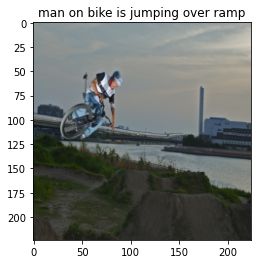

Epoch: 13 loss: 3.27414


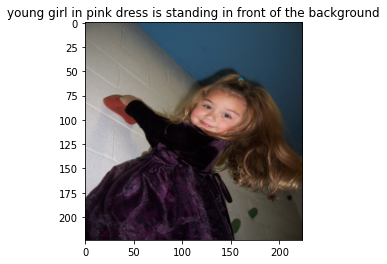

Epoch: 13 loss: 3.09510


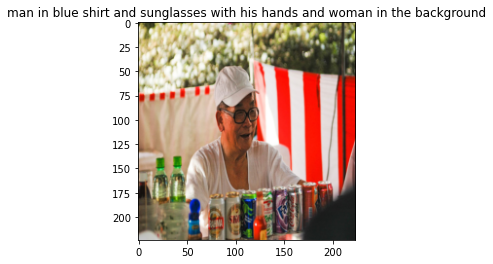

Epoch: 14 loss: 3.27138


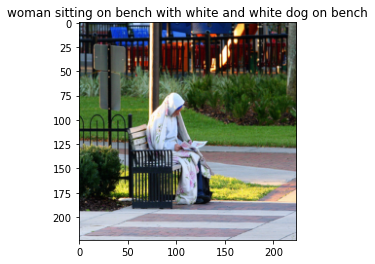

Epoch: 14 loss: 3.24786


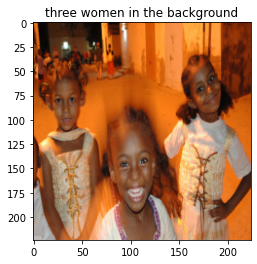

Epoch: 14 loss: 3.07136


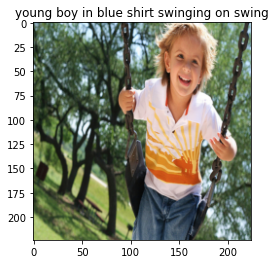

Epoch: 14 loss: 3.06346


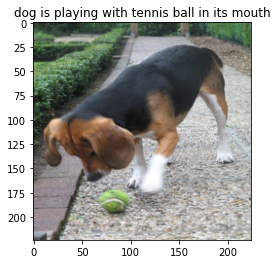

In [118]:
######################
### Training Loop ####
######################

# Hyperparameters
batch_size = 64
embed_size = 256
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 1e-4

max_length_text = 20

annotations_file = 'Dataset/flickr8k/captions.txt'
image_dir = 'Dataset/flickr8k/Images/'

# Initiate the Dataset and Dataloader
train_set, vocab = create_dataset(annotations_file, image_dir)
train_sampler, valid_sampler = train_valid_split(train_set, validation_size=0.3)
train_loader, val_loader = build_loaders(train_set, train_sampler, valid_sampler,
                                         batch_size=batch_size, valid_size=0.3, num_workers=1)

# vocab_size
vocab_size = train_set.vocab_size

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is: {device}')


# Init the model
model = EncoderCNNAttentionDecoderRNN(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    device=device
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=train_set.word_to_idx_mapping["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epochs_num = 14
print_every_num_iters = 100

for epoch in range(1, epochs_num + 1):

    for idx, data in enumerate(train_loader):

        image, captions = data['image'], data['caption']
        image = image.type(torch.FloatTensor)

        # To device
        image, captions = image.to(device), captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs, attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters
        optimizer.step()

        if (idx + 1) % print_every_num_iters == 0:

            print("Epoch: {} loss: {:.5f}".format(epoch, loss.item()))

            # generate the caption
            model.eval()
            with torch.no_grad():
                sampling_and_captioning(train_loader, train_set, model, device, max_length_text)

            model.train()



## Generate prediction on the validation set

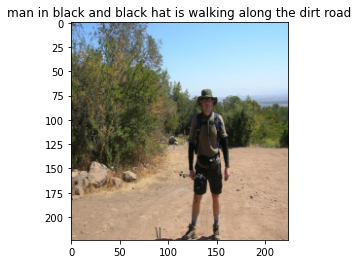

In [122]:
model.eval()
with torch.no_grad():
    sampling_and_captioning(train_loader, train_set, model, device, max_length_text)


## Visualize the Attention Weights

Caption: two dogs are running on the grass


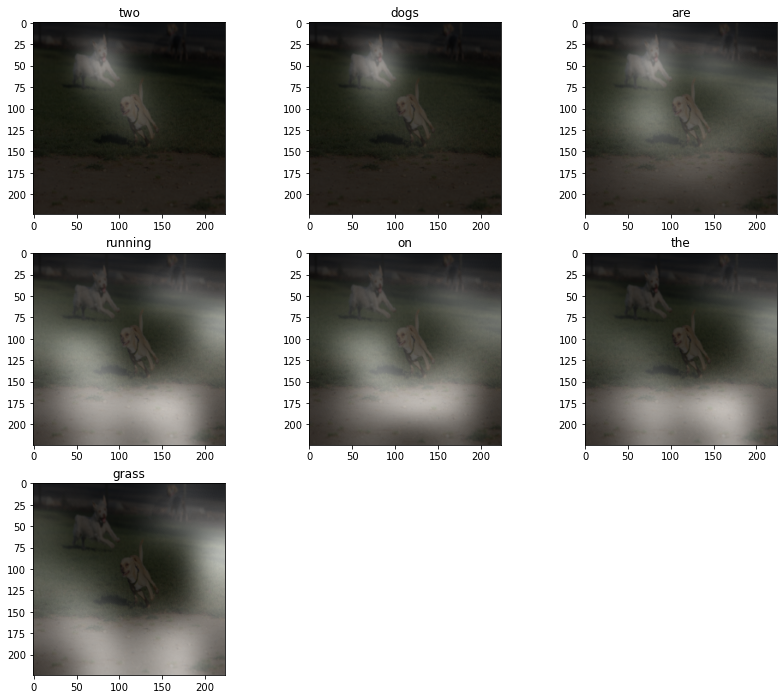

In [133]:
fig = plt.figure(figsize=(14, 12))

data_loader = train_loader
data_set = train_set

data = next(iter(data_loader))  # randomly sample data
image = data['image']
features = model.encoder_cnn(image[0:1].to(device))
words, alphas = model.attention_decoder_rnn.generate_caption(features, max_length_text=15, data_set=data_set)
caption = ' '.join(words)
# show_image(image[0], title=caption)
len_tokens = len(words)

origin_image = image[0]
# unnormalize
origin_image[0] = origin_image[0] * 0.229
origin_image[1] = origin_image[1] * 0.224
origin_image[2] = origin_image[2] * 0.225
origin_image[0] += 0.485
origin_image[1] += 0.456
origin_image[2] += 0.406
origin_image = origin_image.numpy().transpose((1, 2, 0))

print(f'Caption: {caption}')

for i in range(len_tokens):

    attenion_current = alphas[i]
    attenion_current = attenion_current.reshape(7,7)
    ax = fig.add_subplot(len_tokens//2, len_tokens//2, i+1)
    ax.set_title(words[i])
    img = ax.imshow(origin_image)
    ax.imshow(attenion_current, cmap='gray', alpha=0.8, extent=img.get_extent(), interpolation = 'bicubic')


Caption: woman and woman sitting on bench with dog


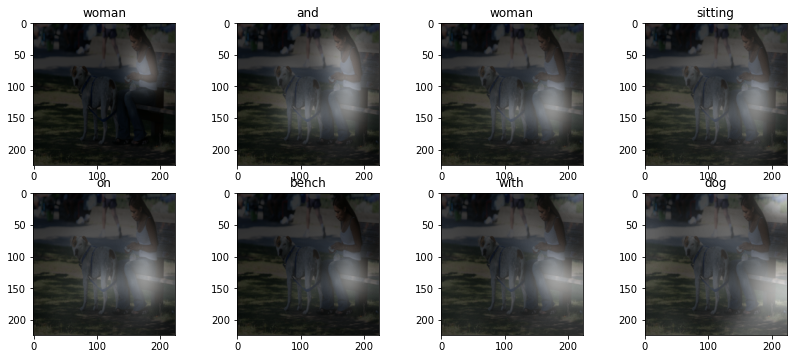

In [131]:
fig = plt.figure(figsize=(14, 12))

data_loader = train_loader
data_set = train_set

data = next(iter(data_loader))  # randomly sample data
image = data['image']
features = model.encoder_cnn(image[0:1].to(device))
words, alphas = model.attention_decoder_rnn.generate_caption(features, max_length_text=15, data_set=data_set)
caption = ' '.join(words)
# show_image(image[0], title=caption)
len_tokens = len(words)

origin_image = image[0]
# unnormalize
origin_image[0] = origin_image[0] * 0.229
origin_image[1] = origin_image[1] * 0.224
origin_image[2] = origin_image[2] * 0.225
origin_image[0] += 0.485
origin_image[1] += 0.456
origin_image[2] += 0.406
origin_image = origin_image.numpy().transpose((1, 2, 0))

print(f'Caption: {caption}')

for i in range(len_tokens):

    attenion_current = alphas[i]
    attenion_current = attenion_current.reshape(7,7)
    ax = fig.add_subplot(len_tokens//2, len_tokens//2, i+1)
    ax.set_title(words[i])
    img = ax.imshow(origin_image)
    ax.imshow(attenion_current, cmap='gray', alpha=0.8, extent=img.get_extent(), interpolation = 'bicubic')


# Done!